In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check for GPU availability
print("Is the GPU available?", tf.config.list_physical_devices('GPU'))

# Get detailed device info
print("Devices:", tf.config.experimental.list_physical_devices())


TensorFlow version: 2.16.2
Is the GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Loading the data

In [3]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

label is 1


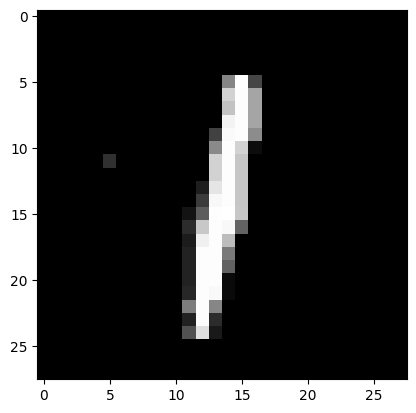

In [4]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [5]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

2025-02-05 13:53:29.394673: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-02-05 13:53:29.394692: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-05 13:53:29.394697: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-05 13:53:29.394708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-05 13:53:29.394716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digits (InputLayer)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([0, 8, 0, 8, 7, 8, 7, 5, 7, 0, 1, 8, 0, 8, 7, 0, 8, 8, 8, 0, 8, 0,
       8, 8, 8, 8, 5, 8, 8, 7])

In [7]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities. 

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [8]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
    
        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [9]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]
        
    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [10]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3221262

# 4. Training the model

### Question 4.1
How many optimization variables are we going to train using this model?

**Answer**: We are optimizing 26.506 parameters (weights).

### Question 5.1
Using the helper code, implement stochastic gradient descent.

**Answer**: Below is the implementation of the mini-batch SGD. To run the regular SGD, we can simply set `epochs=1` and `batch_size=1`

In [11]:
# Stochastic gradient algorithm

# TO IMPLEMENT
def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1, delta_it=1_000):  
    N = len(x_train)
    loss_values = []
    
    for epoch in range(epochs):
        idx = np.random.permutation(N)
        x_train = x_train[idx]
        y_train = y_train[idx]
        
        for k, batch in enumerate(range(0, N, batch_size)):
            x_train_batch = x_train[batch:batch + batch_size]
            y_train_batch = y_train[batch:batch + batch_size]
            
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)
                loss_value = loss(y_train_batch, logits)
                
            grad = tape.gradient(loss_value, model.trainable_weights)
            
            gamma = - learning_rate / np.sqrt(k + 1)
            update_weights(model, grad, gamma)

            if k % delta_it == 0:
                loss_values.append(mean_loss(model, x_train, y_train))
        if epoch % 10 == 0:
            print(epoch)

    return loss_values

In [12]:
def plot_loss(loss_values, delta_it):
    losses = loss_values
    plt.plot(np.arange(len(losses)) * delta_it, losses)
    plt.show()

    print(np.min(losses))


def train_stats(model):
    predicted_probas = model(x_train)
    y_pred = np.argmax(predicted_probas, 1)

    print(classification_report(y_train, y_pred))
    

def test_stats(model):
    predicted_probas = model(x_test)
    y_pred = np.argmax(predicted_probas, 1)

    print(classification_report(y_test, y_pred))

### Question 5.2

Run it for one pass over the data (also called one epoch) and with a step size that satisfies
the conditions required by theory.
Plot the objective value as a function of the iterations. Compare different step size
choices. What do you observe?

0


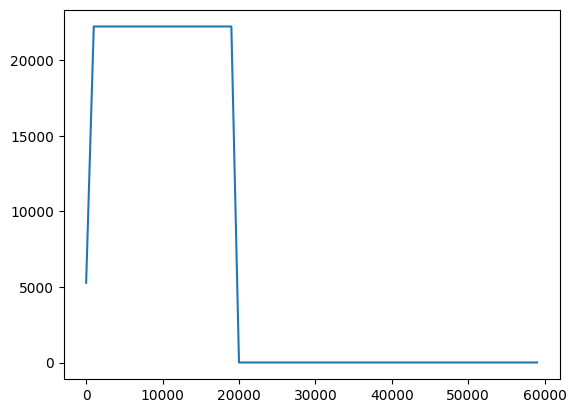

2.3050783
0


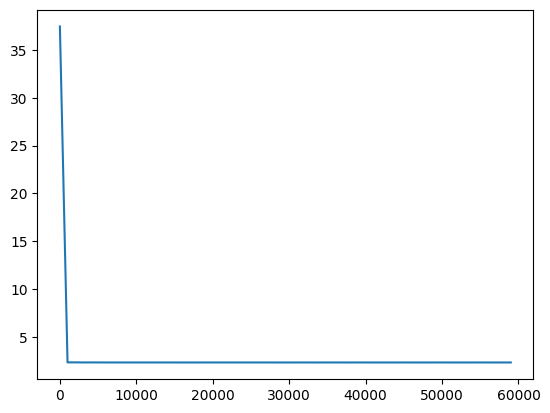

2.301594
0


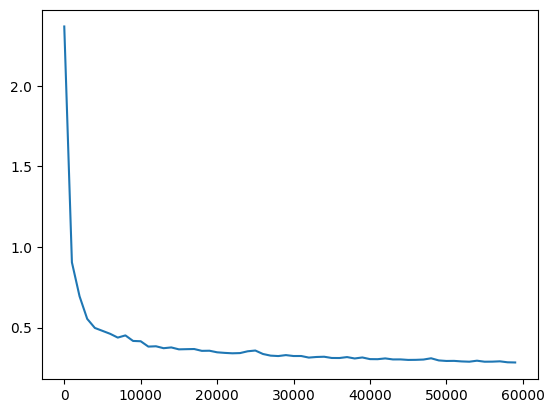

0.28365567
0


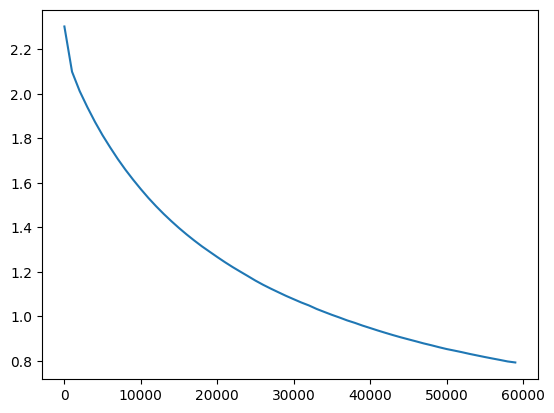

0.79231656
0


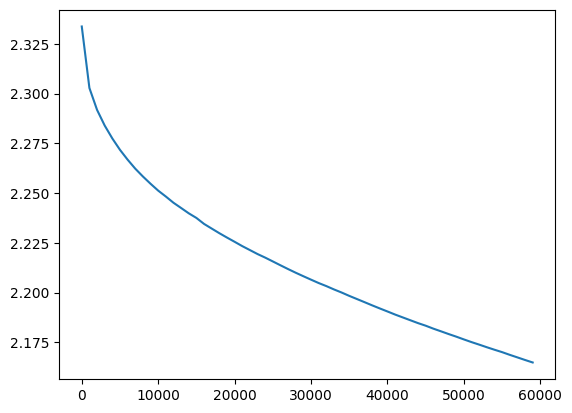

2.1648426


In [13]:
# initialize model
delta_it = 1_000

model = build_model()
loss_values = SGD(model, x_train, y_train, 10, 1, 1, delta_it)
plot_loss(loss_values, delta_it)

model = build_model()
loss_values = SGD(model, x_train, y_train, 1, 1, 1, delta_it)
plot_loss(loss_values, delta_it)

model = build_model()
loss_values = SGD(model, x_train, y_train, 0.1, 1, 1, delta_it)
plot_loss(loss_values, delta_it)

model = build_model()
loss_values = SGD(model, x_train, y_train, 0.01, 1, 1, delta_it)
plot_loss(loss_values, delta_it)

model = build_model()
loss_values = SGD(model, x_train, y_train, 0.001, 1, 1, delta_it)
plot_loss(loss_values, delta_it)

**Answer**: All executions converged after enough iterations. The best step size observed was $\gamma = 0.1$.

### Question 6.1

Run stochastic gradient descent for 5 epochs and compare.

0


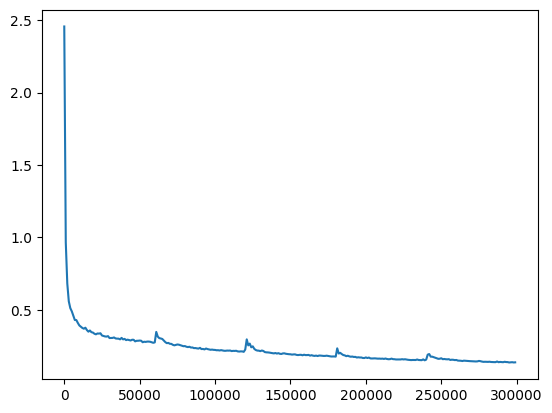

0.13692014


In [14]:
delta_it = 1_000

gamma0 = 0.1

model = build_model()
loss_values = SGD(model, x_train, y_train, gamma0, 5, 1, delta_it)
plot_loss(loss_values, delta_it)

**Answer**: We see that the result obtained is even better. The small peaks in the loss function happen when a new epoch starts and the learning rate is restarted to $\gamma_0$.

### Question 6.2
According to you, what is the advantage of such a scheme?

**Answer**: We know that the estimator of the gradient of $F$ is unbiased, but by using more data, we reduce the variance of this estimator, i.e., the quadratic risk.

### Question 6.3

Implement mini-batch stochastic gradient descent and compare.

In [15]:
# initialize model
model = build_model()

gamma0 = 0.004
epochs = 36
batch_size = 120

delta_it = 1_000

# run SGD
loss_values = SGD(model, x_train, y_train, gamma0, epochs, batch_size, delta_it)

0
10
20
30


0.08375887


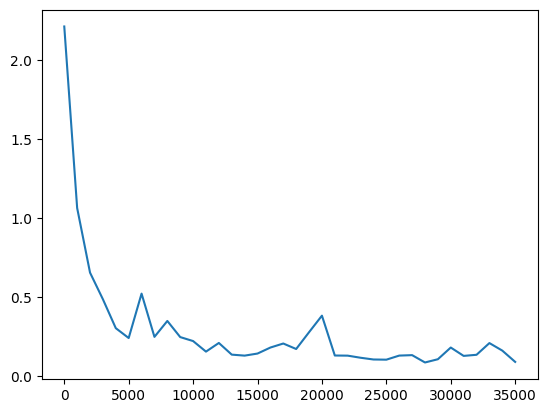

In [16]:
losses = loss_values
plt.plot(np.arange(len(losses)) * delta_it, losses)

print(np.min(losses))

**Answer**: As we can see through the metric, the mini-batch SGD performs better than previous models.

In [17]:
train_stats(model)

test_stats(model)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.98      0.98      0.98      5958
           3       0.98      0.97      0.98      6131
           4       0.98      0.98      0.98      5842
           5       0.98      0.98      0.98      5421
           6       0.98      0.99      0.99      5918
           7       0.99      0.98      0.99      6265
           8       0.98      0.97      0.98      5851
           9       0.97      0.98      0.97      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96 